In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import KFold
import pandas as pd
%matplotlib inline
import copy

In [2]:
class Loss(object):
    
    def __call__(self, predicted, actual):
        """Calculates the loss as a function of the prediction and the actual.
        
        Args:
          predicted (np.ndarray, float): the predicted output labels
          actual (np.ndarray, float): the actual output labels
          
        Returns: (float) 
          The value of the loss for this batch of observations.
        """
        raise NotImplementedError
        
    def derivative(self, predicted, actual):
        """The derivative of the loss with respect to the prediction.
        
        Args:
          predicted (np.ndarray, float): the predicted output labels
          actual (np.ndarray, float): the actual output labels
          
        Returns: (np.ndarray, float) 
          The derivatives of the loss.
        """
        raise NotImplementedError
        
        
class SquaredErrorLoss(Loss):
    
    def __call__(self, predicted, actual):
        return 0.5*np.sum(
            np.multiply((predicted - actual), (predicted - actual))
        )
    
    def delta(self, z_prime, predicted, actual):
        return (
            np.multiply((predicted - actual), z_prime.T)
        )

class crossEntropy(Loss):
    
    def __call__(self, predicted, actual):
        return np.sum(
            np.nan_to_num(np.multiply(-actual,np.log(predicted))-np.multiply((1-actual),np.log(1-predicted)))
        )
    
    def delta(self, z_prime, predicted, actual):
        return (
            (predicted-actual)
        )

In [3]:
class ActivationFunction(object):
        
    def __call__(self, a):
        """Applies activation function to the values in a layer.
        
        Args:
          a (np.ndarray, float): the values from the previous layer (after 
            multiplying by the weights.
          
        Returns: (np.ndarray, float) 
          The values h = g(a).
        """
        return a
    
    def derivative(self, h):
        """The derivatives as a function of the outputs at the nodes.
        
        Args:
          h (np.ndarray, float): the outputs h = g(a) at the nodes.
          
        Returns: (np.ndarray, float) 
          The derivatives dh/da.
        """
        return np.ones(h.shape)
    
class ReLU(ActivationFunction):
    
    def __call__(self, a):
        return np.where(a > 0, a, 0)
    
    def derivative(self, a):
        return np.where(a > 0, 1, 0)

class Sigmoid(ActivationFunction):
    
    def __call__(self, a):
        return 1/(1 + np.exp(-a))
    
    def derivative(self, a):
        e = self.__call__(a)
        return  np.multiply(e, (1 - e))

In [4]:
class Layer(object):
    """A data structure for a layer in a neural network.
    
    Attributes:
      num_nodes (int): number of nodes in the layer
      activation_function (ActivationFunction)
      values_pre_activation (np.ndarray, float): most recent values
        in layer, before applying activation function
      values_post_activation (np.ndarray, float): most recent values
        in layer, after applying activation function
    """
    
    def __init__(self, num_nodes, activation_function=ActivationFunction()):
        self.num_nodes = num_nodes
        self.activation_function = activation_function
        
    def get_layer_values(self, values_pre_activation):
        """Applies activation function to values from previous layer.
        
        Stores the values (both before and after applying activation 
        function)
        
        Args:
          values_pre_activation (np.ndarray, float): 
            A (batch size) x self.num_nodes array of the values
            in layer before applying the activation function
        
        Returns: (np.ndarray, float)
            A (batch size) x self.num_nodes array of the values
            in layer after applying the activation function
        """
        self.values_pre_activation = values_pre_activation
        self.values_post_activation = self.activation_function(
            values_pre_activation
        )
        return self.values_post_activation
    
    def get_layer_derivatives(self, values_pre_activation):
        return self.activation_function.derivative(
            values_pre_activation
        )

In [5]:
class FullyConnectedNeuralNetwork(object):
    """A data structure for a fully-connected neural network.
    
    Attributes:
      layers (Layer): A list of Layer objects.
      loss (Loss): The loss function to use in training.
      learning_rate (float): The learning rate to use in backpropagation.
      weights (list, np.ndarray): A list of weight matrices,
        length should be len(self.layers) - 1
      biases (list, float): A list of bias terms,
        length should be equal to len(self.layers)
    """
    
    def __init__(self, layers, loss, learning_rate):
        self.layers = layers
        self.loss = loss
        self.learning_rate = learning_rate
        
        # initialize weight matrices and biases to zeros
        self.weights = []
        self.biases = []
        mu, sigma = 0, 1
        for i in range(1, len(self.layers)):
            w = np.matrix(np.random.normal(mu, sigma, (self.layers[i - 1].num_nodes, self.layers[i].num_nodes))/np.sqrt(self.layers[i - 1].num_nodes))
            self.weights.append(w)
            self.biases.append(np.zeros(self.layers[i].num_nodes))
        
    def feedforward(self, inputs):
        """Predicts the output(s) for a given set of input(s).
        
        Args:
          inputs (np.ndarray, float): A (batch size) x self.layers[0].num_nodes array
          
        Returns: (np.ndarray, float) 
          An array of the predicted output labels, length is the batch size
        """
        self.storedValuesZ = [inputs]
        self.storedValuesA = [inputs]
        a = inputs
        
        ## Iterate layers
        for i, layer in enumerate(self.layers):
            ## g(hw + b),  h = previous layer values
            if i != len(self.layers) - 1:
                z = np.matrix(np.add(a * self.weights[i], np.matrix(self.biases[i])))
                self.storedValuesZ.append(z)
                a = np.matrix(self.layers[i + 1].get_layer_values(z))
                self.storedValuesA.append(a)
        return a
    
    def predict(self, inputs):
        a = inputs
        ## Iterate layers
        for i, layer in enumerate(self.layers):
            ## g(hw + b),  h = previous layer values
            if i != len(self.layers) - 1:
                z = np.matrix(np.add(a * self.weights[i], np.matrix(self.biases[i])))
                a = self.layers[i+1].get_layer_values(z)
        return a
    
    def backProp(self, predicted, actual):
        gradient_b = [np.zeros(b.shape) for b in self.biases]
        gradient_w = [np.zeros(w.shape) for w in self.weights]
        # Update First weights
        z_prime = 0
        if (type(self.loss) == type(SquaredErrorLoss())):
            z_prime = self.layers[-1].get_layer_derivatives(self.storedValuesZ[-1]).T
        delta = self.loss.delta(z_prime, predicted, actual).T
        dLdw = np.multiply(delta,self.storedValuesA[-2]).T
        
        gradient_b[-1] = delta.T
        gradient_w[-1] = dLdw
        #self.updatedWeights[-1]= self.weights[-1] - self.learning_rate * dLdw
        #self.updatedBiases[-1] = self.biases[-1] - np.multiply(self.learning_rate, delta).T
        
        # Update rest of the weights
        for l in range(2, len(self.layers)):
            z = self.storedValuesZ[-l]
            dadz = self.layers[-l].get_layer_derivatives(z)
            delta = np.multiply(self.weights[-l + 1] * delta, dadz.T)
            dLdw = np.multiply(delta, self.storedValuesA[-l - 1]).T
            gradient_b[-l] = delta.T
            gradient_w[-l] = dLdw
            #self.updatedBiases[-l] = self.biases[-l] - np.multiply(self.learning_rate, delta).T
            #self.updatedWeights[-l] = self.weights[-l] - np.multiply(self.learning_rate, np.dot(delta, self.storedValuesA[-l - 1])).T
        return (gradient_b, gradient_w)
        
    def train(self, inputs, labels):
        """Trains neural network based on a batch of training data.
        
        Args:
          inputs (np.ndarray): A (batch size) x self.layers[0].num_nodes array
          labels (np.ndarray): An array of ground-truth output labels, 
            length is the batch size.
        """
        predicted = self.feedforward(inputs)
        gradient_b, gradient_w = self.backProp(predicted, labels)
        return (gradient_b, gradient_w, self.loss(predicted,labels))
    
    def getWeights(self):
        return(self.weights)
    
    def train_epochs_minibatch(self, inputs, labels, epochs = 10, mini_batch=1):
        '''
        Args:
          inputs (np.ndarray): A x self.layers[0].num_nodes array
          labels (np.ndarray): An array of ground-truth output labels, 
            length is the inputs size.
          epochs (int): Number of times the data is iterated through
          mini_batch (int): Number of observations to train at a time
        '''
        if (inputs.shape[0] < mini_batch):
            mini_batch = inputs.shape[0]
        meanLossEpochs = []
        for i in range(epochs):
            print('Epoch#:',i)
            sum_gradient_b = [np.zeros(b.shape) for b in self.biases]
            sum_gradient_w = [np.zeros(w.shape) for w in self.weights]
            sumLoss = 0
            randomIndices = np.random.choice([i for i in range(len(inputs))], size=inputs.shape[0], replace=False)
            for index, row in enumerate(randomIndices):
                gradient_b, gradient_w, loss = self.train(np.matrix([inputs[row]]),np.matrix([labels[row]]))
                sumLoss += loss
                sum_gradient_b = [sb+gb for sb, gb in zip(sum_gradient_b,gradient_b)]
                sum_gradient_w = [sw+gw for sw, gw in zip(sum_gradient_w, gradient_w)]
                if ((index+1)%mini_batch == 0 or (index+1) == inputs.shape[0]):
                    self.biases = [b-(self.learning_rate/mini_batch)*sb
                                      for b, sb in zip(self.biases, sum_gradient_b)]
                    self.weights = [w-(self.learning_rate/mini_batch)*sw
                                     for w, sw in zip(self.weights, sum_gradient_w)]
                    sum_gradient_b = [np.zeros(b.shape) for b in self.biases]
                    sum_gradient_w = [np.zeros(w.shape) for w in self.weights]
            avg_loss = sumLoss/inputs.shape[0]
            meanLossEpochs.append(avg_loss)
        return (meanLossEpochs)

In [6]:
# Sigmoid must be applied to the last layer inorder for it to work
network = FullyConnectedNeuralNetwork(
    layers=[Layer(179), Layer(50, ReLU()), Layer(20), Layer(1, Sigmoid())],
    loss = crossEntropy(),
    learning_rate=0.005
)

In [7]:
test = pd.read_csv("train.csv")

In [8]:
test.head()

,ABV,appearance,aroma,overall,palate,taste,userBias,word_count,char_count,avg_word_len,...,Spain,Sri Lanka,Sweden,Switzerland,"Taiwan, Province of China",Thailand,Togo,United Kingdom,United States,Location Unknown
0,0.092014,0.7,0.750,1.0,0.750,0.875,0.745000,0.135593,0.135916,0.312620,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.192708,0.8,1.000,1.0,1.000,1.000,0.766250,0.238418,0.232877,0.270866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.111111,0.8,0.875,1.0,0.875,0.875,0.775000,0.114124,0.119221,0.425918,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.123264,0.8,0.875,1.0,0.750,0.875,0.711000,0.213559,0.221747,0.344344,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.175347,0.8,0.875,1.0,0.875,0.875,0.755556,0.211299,0.209332,0.288806,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [33]:
dependents = ['overall']#['taste','appearance','aroma','palate','overall']

In [31]:
independents = []
for x in list(test.columns):
    if (x not in dependents):
        independents.append(x)

In [32]:
len(independents)

179

In [16]:
def makeXandY(data, dependentNames, independentName, intercept):
    X = np.array(data[dependentNames])
    if (intercept):
        X = np.insert(X, 0, 1, axis=1)
    y = np.array(data[independentName])
    return X, y

In [34]:
x, y = makeXandY(test, independents, dependents, False)

In [35]:
x.shape

(37500, 179)

In [36]:
y.shape

(37500, 1)

In [37]:
randomize = np.random.choice([i for i in range(x.shape[0])], size=x.shape[0], replace=False)

In [38]:
testX = x[randomize[:3750]]
testY = y[randomize[:3750]]
trainX = x[randomize[3750:]]
trainY = y[randomize[3750:]]

In [39]:
epochsMeanError = network.train_epochs_minibatch(trainX, trainY, epochs=20, mini_batch=100)

Epoch#: 0
Epoch#: 1
Epoch#: 2
Epoch#: 3
Epoch#: 4
Epoch#: 5
Epoch#: 6
Epoch#: 7
Epoch#: 8
Epoch#: 9
Epoch#: 10
Epoch#: 11
Epoch#: 12
Epoch#: 13
Epoch#: 14
Epoch#: 15
Epoch#: 16
Epoch#: 17
Epoch#: 18
Epoch#: 19


In [40]:
# Predict to find error
predict = network.predict(testX)

In [31]:
diff = predict - testY

In [32]:
squardDiff = np.multiply(diff,diff)

In [35]:
mse = np.sum(squardDiff, axis = 0)/testY.shape[0]

In [36]:
mse # Great but not standardized

matrix([[ 0.02006457,  0.00940888,  0.01782851,  0.01783685,  0.0133131 ]])

# Unstandardized predicted for each dependent

In [41]:
unstandPredict = copy.deepcopy(predict)
unstandPredict[:,0] = predict[:,0]*5+(-1e-08)
unstandTestY = copy.deepcopy(testY)
unstandTestY[:,0] = testY[:,0]*5+(-1e-08)

In [42]:
diff = unstandPredict - unstandTestY
squardDiff = np.multiply(diff,diff)
mse = np.sum(squardDiff, axis = 0)/unstandTestY.shape[0]
print(mse)

[[ 0.34713103]]


In [43]:
np.var(unstandPredict, axis= 0)

matrix([[ 0.06381652]])

# Unstandardized predicted for all dependents

In [37]:
nonRegData = pd.read_csv('train_not_reg.csv')

In [38]:
nonRegData.head()

,ABV,appearance,aroma,overall,palate,taste,userBias,word_count,char_count,avg_word_len,...,Spain,Sri Lanka,Sweden,Switzerland,"Taiwan, Province of China",Thailand,Togo,United Kingdom,United States,Location Unknown
0,5.4,3.5,4.0,5.0,4.0,4.5,0.459960,121,684.0,4.432000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11.2,4.0,5.0,5.0,5.0,5.0,0.884960,212,1137.0,4.240741,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,6.5,4.0,4.5,5.0,4.5,4.5,1.059960,102,606.0,4.950980,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,7.2,4.0,4.5,5.0,4.0,4.5,-0.220040,190,1085.0,4.577320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,10.2,4.0,4.5,5.0,4.5,4.5,0.671071,188,1027.0,4.322917,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [40]:
# Formula used to standardize
# minimum = train[col].min()
# maximum = train[col].max()
# train[col] = (train[col]-(minimum-.00000001)) / (maximum-minimum)
# dependents = ['taste','appearance','aroma','palate','overall']
for dep in dependents:
    print(dep)
    minDep = nonRegData[dep].min()
    maxDep = nonRegData[dep].max()
    print('multiply',(maxDep-minDep))
    print('add', minDep-.00000001)
    

taste
multiply 4.0
add 0.99999999
appearance
multiply 5.0
add -1e-08
aroma
multiply 4.0
add 0.99999999
palate
multiply 4.0
add 0.99999999
overall
multiply 5.0
add -1e-08


In [60]:
predict

matrix([[ 0.75892335,  0.79785564,  0.75117496,  0.74622054,  0.79041425],
        [ 0.82727774,  0.84774871,  0.81565502,  0.80789164,  0.860271  ],
        [ 0.70340177,  0.7539783 ,  0.68781594,  0.69721566,  0.74261862],
        ..., 
        [ 0.87886278,  0.8743032 ,  0.86785127,  0.8516397 ,  0.88950593],
        [ 0.7931613 ,  0.80482041,  0.77662379,  0.77152569,  0.82538341],
        [ 0.70215509,  0.77150605,  0.69863589,  0.68523435,  0.7721432 ]])

# Neural Network with all dependents results:

In [61]:
unstandPredict = copy.deepcopy(predict)
unstandPredict[:,0] = predict[:,0]*4+0.99999999
unstandPredict[:,1] = predict[:,1]*5+(-1e-08)
unstandPredict[:,2] = predict[:,2]*4+0.99999999
unstandPredict[:,3] = predict[:,3]*4+0.99999999
unstandPredict[:,4] = predict[:,4]*5+-1e-08

In [65]:
np.var(unstandPredict, axis= 0)

matrix([[ 0.09117546,  0.06986612,  0.10521375,  0.09441194,  0.09628214]])

In [62]:
unstandTestY = copy.deepcopy(testY)
unstandTestY[:,0] = testY[:,0]*4+0.99999999
unstandTestY[:,1] = testY[:,1]*5+(-1e-08)
unstandTestY[:,2] = testY[:,2]*4+0.99999999
unstandTestY[:,3] = testY[:,3]*4+0.99999999
unstandTestY[:,4] = testY[:,4]*5+-1e-08

In [64]:
diff = unstandPredict - unstandTestY
squardDiff = np.multiply(diff,diff)
mse = np.sum(squardDiff, axis = 0)/unstandTestY.shape[0]
print(mse)

[[ 0.32103305  0.23522205  0.28525619  0.28538954  0.33282746]]


# Plot learning rates

In [140]:
import matplotlib.pyplot as plt
%matplotlib inline

In [199]:
xs = np.arange(20)

Text(0.5,1,'NN One Dependent: taste')

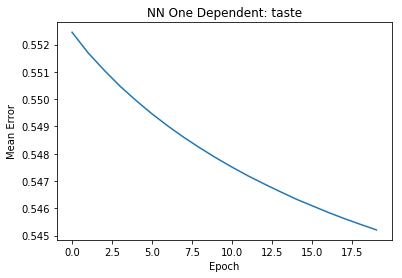

In [201]:
plt.plot(xs,epochsMeanError)
plt.xlabel('Epoch')
plt.ylabel('Mean Error')
plt.title("NN One Dependent: taste")

Text(0.5,1,'Squared Error Loss Function')

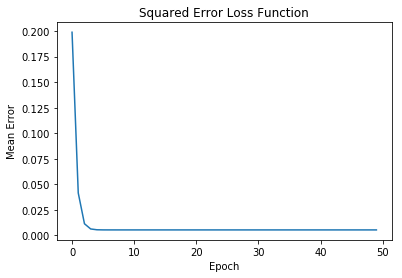

In [35]:
plt.plot(xs,epochsMeanError)
plt.xlabel('Epoch')
plt.ylabel('Mean Error')
plt.title("Squared Error Loss Function")

In [202]:
sumMSE = 0.015206818375849451 + 0.018871498462694727 + 0.037666860687320523 + 0.022874488092096194 + 0.015563367413306953

In [203]:
sumMSE / 5

0.02203660660625357